<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw1/hw1p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from google.colab import drive
from tqdm import tnrange
import matplotlib.pyplot as plt
import torchvision

In [0]:
device = torch.device("cuda:0")
path_ = os.path.join('drive', 'My Drive', 'mnist-hw1.pkl')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
with open(path_, 'rb') as file:
    dataset = pickle.load(file)
    
X_train, X_test = dataset['train'], dataset['test']

In [0]:
def plot_loss(loss_train, loss_val):
    plt.plot(np.arange(len(loss_train)), loss_train, label='train')
    plt.plot(np.arange(len(loss_val)), loss_val, label='validate')
    plt.legend()
    plt.title("losses")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.show()

In [0]:
def collate_fn(x):
    return torch.LongTensor(x).permute(0, 3, 1, 2)

In [0]:
def loss_function(p, x):
    p = F.softmax(p, dim=-1)
    x = F.one_hot(x, 4).float()
    p = (p * x).sum(dim=-1)
    return -torch.log(p + 1e-9).mean()

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, channel_in, channel_out, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(channel_in, channel_out, kernel_size, stride, padding, bias=False)
        mask = torch.ones_like(self.weight)
        _, _, h, w = self.weight.size()
        h, w = h // 2, w // 2
        mask[:, :, h, w + (mask_type == 'B'):] = 0
        mask[:, :, h + 1:] = 0
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [0]:
class MaskResBlock(nn.Module):
    def __init__(self, h):
        super(MaskResBlock, self).__init__()
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * h, h, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            MaskedConv2d('B', h, h, 3, 1, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            nn.Conv2d(h, 2 * h, 1),
            nn.BatchNorm2d(2 * h)
        )

    def forward(self, x):
        return self.net(x) + x

In [0]:
class PixelCNN(nn.Module):
    def __init__(self, h):
        super(PixelCNN, self).__init__()
        self.net = nn.Sequential(
            MaskedConv2d('A', 3, 2 * h, 7, 1, 3),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            nn.ReLU(),
            nn.Conv2d(2 * h, 2 * h, 1),
            nn.BatchNorm2d(2 * h),
            nn.ReLU(),
            nn.Conv2d(2 * h, 3 * 4, 1)
        )

    def forward(self, x):
        n, c, h, w = x.shape
        return self.net(x.float()).reshape(n, c, 4, h, w).permute(0, 1, 3, 4, 2)

In [0]:
train_loader = data.DataLoader(dataset=X_train, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = data.DataLoader(dataset=X_test, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [0]:
epochs_num = 12
model = PixelCNN(h=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train():
    loss_train, loss_val = [], []

    for i in tnrange(epochs_num):
        losses = []
        model.train()
        for xs in train_loader:
            xs = xs.to(device)
            optimizer.zero_grad()
            loss = loss_function(model(xs), xs)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        loss_train.append(np.array(losses).mean())

        losses = []
        model.eval()
        with torch.no_grad():
            for xs in val_loader:
                xs = xs.to(device)
                loss = loss_function(model(xs), xs)
                losses.append(loss.item())

        loss_val.append(np.array(losses).mean())

    return loss_train, loss_val

In [0]:
loss_train, loss_val = train()

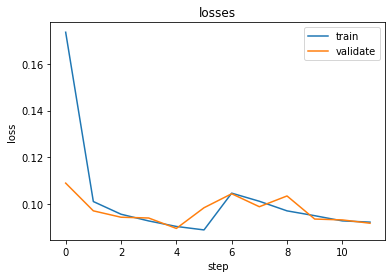

In [0]:
plot_loss(loss_train, loss_val)

In [0]:
def sample_images(model, n=24):
    samples = np.zeros((n, 28, 28, 3), dtype=np.uint8)
    with torch.no_grad():
        for y in tnrange(28):
            for x in range(28):
                for c in range(3):
                    xs = collate_fn(samples)
                    ps = model(xs.cuda()).cpu()
                    ps = F.softmax(ps, dim=4).numpy()
                    for i in range(n):
                        samples[i, y, x, c] = np.random.choice(4, p=ps[i, c, y, x])
                        
    return samples * 85

In [0]:
model.eval()
samples = sample_images(model)

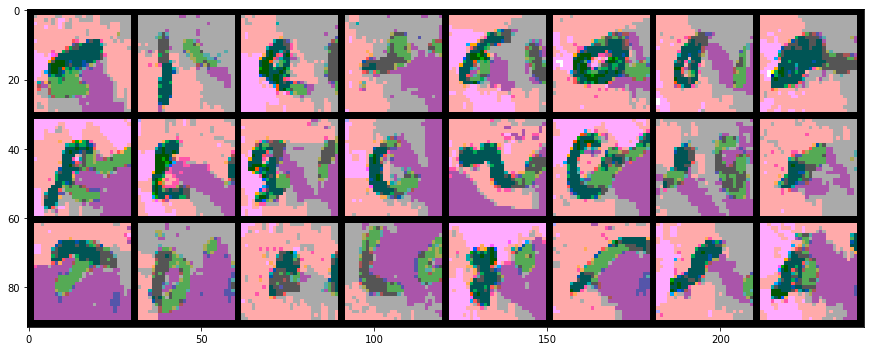

In [0]:
image = torchvision.utils.make_grid(torch.from_numpy(samples.swapaxes(3, 2).swapaxes(2, 1)).long(), nrow=3).cpu().numpy()
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(image, (2, 1, 0)))

In [0]:
def receptive_field(model, X):
    hs = 14
    x = torch.tensor(X.numpy().astype(np.float32), requires_grad=True, device=device)
    loss = loss_function(model(x)[:, 0, hs, hs].cpu(), X[:, 0, hs, hs].cpu()).backward()
    
    plt.imshow(x.grad.abs().sum(dim=(0, 1)).cpu().float().numpy())
    plt.show()

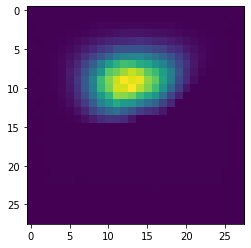

In [0]:
model2 = PixelCNN(h=128).to(device)
X = collate_fn(X_test[:100])
receptive_field(model2, X)